### Compute and store filtered and demodulated velocity field along simulated drifters trajectories

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp
import pyinterp

from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster() #processes=7, cores=7
#
w = cluster.scale(jobs=6)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [12]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    
    Parameters
    x : input signal
    h : filter 
    hilbert : True for Hilbert transform to be applied to the filtered signal
    
    Returns
    x_f : filtered signal or hilbert transform of the filtered signal
    """
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f
    
def filt_L(v, h,columns,om, hilbert=False):
    """Call convolve function and returns new dataframe with filtered and demodulated signal
    
    Parameters
    v : input dataframe
    h : filter to use as input in convolve
    columns : columns to filter and demodulate in v
    om : central frequency of h
    hilbert : True for Hilbert transform to be applied to the filtered signal
    
    Returns
    vc : dataframe with new columns with filtered and demodulated signal
    """
    vc = v.copy()
    vc = vc.sort_values('time') #.set_index('time')#
    for V in columns:
        vc[V+'_hat'] = convolve(vc[V],h=h,hilbert=hilbert)
    if hilbert:
        time = np.arange(0,vc.index.size*dt,dt)#.compute()
        exp = np.exp(-1j*om*2*np.pi*time)
        for V in columns:
            vc[V+'_demodulated'] = vc[V+'_hat']*exp
    return vc

#### Load variables along simulated  drifters trajectories (with time as index)

In [4]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
parcels_index = 'trajectory'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df) # convert velocities to m/s
df.head()
print(df.npartitions)
#df = df.get_partition(0).persist()


433


In [5]:
time = df.time.compute()
print('Size : ',time.size)
print('Size unique : ',np.unique(time).size)

Size :  664361334
Size unique :  8643


#### Definition of the filter used along each trajectories to keep only the tidal signal

In [6]:
dt = 1/24 # time step in days

#Band pass filter
tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2","K1","O1","M4","S4")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2 #central frequency

V = ['zonal_velocity','meridional_velocity']
Tw = 30 #filter length
dband=0.2 #half bandwidth

# Generate filter for given parameters : Tw, dband, omega (maximize gain for those choices)
h = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)

In [7]:
#Low pass filter
filter_cutoff = 0.5 # cpd
filter_size = 20 # in days
filter_size_pts = int(20/dt) # in points

import sstats.sigp_AP as sigp
filter_h, filter_t = sigp.lowpass_filter(filter_cutoff, filter_size_pts, dt)
h_hat, w = sigp.filter_response(filter_h, dt)

#### Some cleaning before filtering

In [8]:
def remove_duplicates(df):
    """Find duplicates in dataframe and remove them.
    Create a column 'dt_flag', False if the dt is not different from 1/24
    
    ----------------
    Parameters
    df : dataframe from which duplicates must be removed, dataframe
    
    ----------------
    Returns
    df : input dataframe without duplicates and with new column 'dt_flag', dataframe
    """
#    df = df.reset_index().drop_duplicates('time').sort_values('time')#.set_index('time')
    df = df.drop_duplicates('time').set_index('time')
#    dt_df = df.index[1:]-df.index[:-1]
#    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df



In [9]:
df = df.drop(columns=['sea_level','temperature','salinity']).persist()

In [10]:
# Remove duplicates found in dataframe and create flag column to check that dt is always 1/24
df_drop = df.groupby(df.index).apply(remove_duplicates#,meta=meta
                                   ).persist()
df_drop.head()

/dev/shm/pbs.9809304.datarmor0/ipykernel_46421/2472649859.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_drop = df.groupby(df.index).apply(remove_duplicates#,meta=meta


lat        lon    z  zonal_velocity  \
trajectory time                                                             
1000168    2011-12-25 00:00:00 -73.247185 -21.274311  0.0        0.000000   
           2011-12-25 01:00:00 -73.244513 -21.294828  0.0       -0.194731   
           2011-12-25 02:00:00 -73.242638 -21.316548  0.0       -0.192481   
           2011-12-25 03:00:00 -73.241642 -21.339166  0.0       -0.209434   
           2011-12-25 04:00:00 -73.240820 -21.363171  0.0       -0.217657   

                                meridional_velocity   waterdepth  
trajectory time                                                   
1000168    2011-12-25 00:00:00             0.000000     0.000000  
           2011-12-25 01:00:00             0.092676  1600.397705  
           2011-12-25 02:00:00             0.022685  1669.813232  
           2011-12-25 03:00:00             0.024450  1690.841309  
           2011-12-25 04:00:00             0.007192  1681.142212

In [11]:
# Remove trajectories filled with NaN for some partitions (partition 0 for example), unknown cause
_df_drop = df_drop.reset_index().dropna().persist()
_df_drop.head()

,trajectory,time,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth
0,1000168,2011-12-25 00:00:00,-73.247185,-21.274311,0.0,0.000000,0.000000,0.000000
1,1000168,2011-12-25 01:00:00,-73.244513,-21.294828,0.0,-0.194731,0.092676,1600.397705
2,1000168,2011-12-25 02:00:00,-73.242638,-21.316548,0.0,-0.192481,0.022685,1669.813232
3,1000168,2011-12-25 03:00:00,-73.241642,-21.339166,0.0,-0.209434,0.024450,1690.841309
4,1000168,2011-12-25 04:00:00,-73.240820,-21.363171,0.0,-0.217657,0.007192,1681.142212


#### Filter and demodulation (cf doc overleaf for formula) : 
Along each trajectory:

1) Apply the filter, h, near the semi-diurnal tidal frequency, $\omega$

2) Demodulation of the filtered signal (*$e^{i\omega t}$)

In [13]:
df_filtered = _df_drop.groupby('trajectory').apply(filt_L,filter_h,['zonal_velocity','meridional_velocity']
                                                  ,omega,hilbert=False).persist()
df_filtered.head()

/dev/shm/pbs.9809304.datarmor0/ipykernel_46421/2691077294.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered = _df_drop.groupby('trajectory').apply(filt_L,filter_h,['zonal_velocity','meridional_velocity']


trajectory                time        lat        lon    z  \
trajectory                                                                
1000168    0     1000168 2011-12-25 00:00:00 -73.247185 -21.274311  0.0   
           1     1000168 2011-12-25 01:00:00 -73.244513 -21.294828  0.0   
           2     1000168 2011-12-25 02:00:00 -73.242638 -21.316548  0.0   
           3     1000168 2011-12-25 03:00:00 -73.241642 -21.339166  0.0   
           4     1000168 2011-12-25 04:00:00 -73.240820 -21.363171  0.0   

              zonal_velocity  meridional_velocity   waterdepth  \
trajectory                                                       
1000168    0        0.000000             0.000000     0.000000   
           1       -0.194731             0.092676  1600.397705   
           2       -0.192481             0.022685  1669.813232   
           3       -0.209434             0.024450  1690.841309   
           4       -0.217657             0.007192  1681.142212   

              zonal_velocity_hat  meridional_velocity_hat  
trajectory                                                 
1000168    0           -0.148123                -0.022400  
           1           -0.156951                -0.034309  
           2           -0.164904                -0.046822  
           3           -0.171882                -0.059829  
           4           -0.177794                -0.073213

In [14]:
df_filtered = df_filtered.reset_index(drop=True).persist()

In [15]:
df_filtered = df_filtered.set_index('time').persist()
df_filtered.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,zonal_velocity_hat,meridional_velocity_hat
time,,,,,,,,,
2011-11-15,2000844,-67.226303,0.562500,0.0,0.0,0.0,0.0,-0.037399,-0.038937
2011-11-15,2001062,-68.788177,10.979167,0.0,0.0,0.0,0.0,-0.050828,-0.055424
2011-11-15,2001076,-62.904213,10.979167,0.0,0.0,0.0,0.0,-0.052928,-0.013808
2011-11-15,3001600,-60.772732,31.812500,0.0,0.0,0.0,0.0,0.026066,-0.010228
2011-11-15,4000298,-28.264765,-23.395834,0.0,0.0,0.0,0.0,-0.037163,0.025803


In [16]:
# Check duplicates

time = df_filtered[df_filtered.trajectory==29000231].index.compute()

In [17]:
print('Duplicates: ', time.size!=np.unique(time).size)
if time.size!=np.unique(time).size:
    print('Number of duplicates : ',time.size-np.unique(time).size)

Duplicates:  False


#### Create and store dask dataframe with real and imaginary part of the analytic signal and demodulated signal for velocity fields

In [16]:
for v in ["zonal_velocity","meridional_velocity"]:
    df_filtered[v+"_hat_real"] = df_filtered[v+"_hat"].map_partitions(lambda x : np.real(x)).persist()

    df_filtered[v+"_hat_imag"] = df_filtered[v+"_hat"].map_partitions(lambda x : np.imag(x)).persist()
#    df_filtered[v+"_demodulated_real"] = df_filtered[v+"_demodulated"].map_partitions(lambda x : np.real(x)).persist()
#    df_filtered[v+"_demodulated_imag"] = df_filtered[v+"_demodulated"].map_partitions(lambda x : np.imag(x)).persist()

In [17]:
for v in ["zonal_velocity","meridional_velocity"]:
    df_filtered = df_filtered.drop(columns=[v+"_hat"]).persist() #,v+"_demodulated"

In [18]:
df_filtered

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,zonal_velocity_hat_real,zonal_velocity_hat_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag
npartitions=433,,,,,,,,,,,
2011-11-15 00:00:00,int64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64
2011-11-15 01:00:00,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
2012-11-08 23:00:00,...,...,...,...,...,...,...,...,...,...,...
2012-11-09 01:00:00,...,...,...,...,...,...,...,...,...,...,...


In [19]:
# Store filtered demodulated dataframe
# Title is defined as follow : filtered_itide_Tw{filter length}_sd_band{bandwidth}
ds, dirs = pa.load_logs(root_dir, run_name)
pa.store_parquet(dirs["parquets"], df_filtered, overwrite=True, name="lpass_filtered_05cpd")

No reindexing
create new archive: /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/parquets/lpass_filtered_05cpd


'/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/parquets/lpass_filtered_05cpd'

In [21]:
lon,lat,low_u = df_filtered.lon.compute(),df_filtered.lat.compute(),df_filtered.zonal_velocity_hat_real.compute()


In [22]:
plt.scatter(lon[::6],lat[::6],c=low_u[::6])

Error in callback <function flush_figures at 0x2aabc45fe820> (for post_execute):


KeyboardInterrupt: 

In [22]:
# Cell to load the filtered signal
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
parcels_index = 'filtered_itide_Tw30_sd_band04'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,zonal_velocity_hat_real,zonal_velocity_hat_imag,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag,meridional_velocity_demodulated_real,meridional_velocity_demodulated_imag
time,,,,,,,,,,,,,,,
2011-11-15,2000844,-67.226303,0.562500,0.0,0.0,0.0,0.0,0.002438,0.002383,0.002438,0.002383,-0.001410,0.005584,-0.001410,0.005584
2011-11-15,32001255,-69.530426,-126.770836,0.0,0.0,0.0,0.0,0.000518,-0.006434,0.000518,-0.006434,0.002277,-0.000432,0.002277,-0.000432
2011-11-15,24000949,-40.126877,163.312500,0.0,0.0,0.0,0.0,0.028092,0.000022,0.028092,0.000022,-0.018097,-0.020551,-0.018097,-0.020551
2011-11-15,32001165,-65.565285,-130.937500,0.0,0.0,0.0,0.0,-0.004214,-0.001272,-0.004214,-0.001272,0.000220,-0.000716,0.000220,-0.000716
2011-11-15,24001270,-29.922403,177.895828,0.0,0.0,0.0,0.0,-0.027028,0.013208,-0.027028,0.013208,0.014038,0.009028,0.014038,0.009028


In [23]:
df_test = df[df.trajectory==29000231].compute()

<AxesSubplot:xlabel='time'>

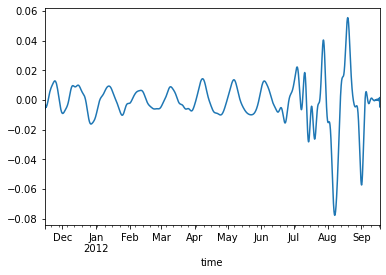

In [24]:
df_test.zonal_velocity_demodulated_real.plot()

In [ ]:
cluster.close()